## Reviews sentiment analysis _(on flipkart)_

In [1]:
import os
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
import spacy

op = webdriver.ChromeOptions()
op.add_argument('headless')

# You will have to download drives here use link given below to download
# https://selenium-python.readthedocs.io/installation.html

driver = webdriver.Chrome(r'D:\DS Notes\Web Scrappting\chromedriver.exe',
                          options=op)

### _Just change the link to get sentiment analysis of any other product (gcp account required)_

In [2]:
# link for oppo A5s mobile

link = 'https://www.flipkart.com/oppo-a5s-blue-32-gb/p/itmffhgzsqaczrn4?pid=MOBFGHYFHHRNZAZF&lid=LSTMOBFGHYFHHRNZAZFYOVTB9&marketplace=FLIPKART&srno=s_1_1&otracker=AS_QueryStore_OrganicAutoSuggest_1_1_na_na_na&otracker1=AS_QueryStore_OrganicAutoSuggest_1_1_na_na_na&fm=SEARCH&iid=41511672-6723-48b2-8387-785fd4e100e5.MOBFGHYFHHRNZAZF.SEARCH&ppt=sp&ppn=sp&ssid=aq4q4w2hb40000001595370472294&qH=c892ba238c98835d'

In [3]:
def get_all_reviews_list(link):
    
    result = requests.get(link)
    main_soup = BeautifulSoup(result.text, 'html.parser')
    
    base_url = 'https://www.flipkart.com'
    
    url = base_url + main_soup.find('div', class_ = 'col _39LH-M').find_all('a', href = re.compile('/product-reviews/'))[-1].get('href')
    
    result = requests.get(url)
    soup = BeautifulSoup(result.text, 'html.parser')
    
    num_of_pages = int(soup.find('div', class_="_2zg3yZ _3KSYCY").find('span').text.split()[-1])
    print('Number of pages are:',num_of_pages)
    
    all_pages_url = []
    for num in np.arange(1,num_of_pages+1):
        page_url = url+'&page='+str(num)
        all_pages_url.append(page_url)
        
    # all_pages_url has url of all the pages
    
    print('Collecting all the reviews... Please wait!! [will take approx',str(num_of_pages/100),'mins]')
    
    start = time.time()
    reviews_list = []
    for page_url in all_pages_url:
        driver.get(page_url)

        for i in driver.find_elements(By.CLASS_NAME , '_1EPkIx'):
            i.click()

        s1 = BeautifulSoup(driver.page_source,'html.parser')

        one_page_reviws = [r.find('div').find('div').text for r in s1.find_all('div', class_="qwjRop")]

        reviews_list.extend(one_page_reviws)
    end = time.time()
    
    print('Time taken is:',str(round((end - start)/60,1)),'mins')
    
    print('\nTotal number of reviews are:', len(reviews_list))
    return reviews_list

In [4]:
all_reviews_list = get_all_reviews_list(link)

Number of pages are: 39
Time taken is: 0.5 mins

Total number of reviews are: 389


In [5]:
## sentiment analysis using google cloud natural language API

from google.cloud import language_v1
from google.cloud.language import enums
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'sanket-ocr-key.json'

def sample_analyze_sentiment(text_content):
    """
    Analyzing Sentiment in a String

    Args:
      text_content The text content to analyze
    """

    client = language_v1.LanguageServiceClient()

    # Available types: PLAIN_TEXT, HTML
    type_ = enums.Document.Type.PLAIN_TEXT

    language = "en"
    document = {"content": text_content, "type": type_, "language": language}

    # Available values: NONE, UTF8, UTF16, UTF32
    encoding_type = enums.EncodingType.UTF8

    response = client.analyze_sentiment(document, encoding_type=encoding_type)
    
    sentiment_score = response.document_sentiment.score
    
    if sentiment_score > 0.2:
        return 'positive'
    elif sentiment_score < -0.2:
        return 'negative'
    else:
        return 'neutral'

In [13]:
def process_text(sentence):

    # Parse the sentence using the loaded 'en' model object `nlp`
    # if you get [Can't find model 'en' error] run this in windows cmd: python -m spacy download en
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    all_stopwords = nlp.Defaults.stop_words

    # lemmatization
#     doc = nlp(sentence)
#     all_words = [token.lemma_ for token in doc]

    # remove stop words, numbers, punctuations, and words with len=1 also get lower words
    all_words = [word.lower() for word in re.findall(r'[a-zA-Z0-9]+',sentence) if word not in all_stopwords and len(word) > 1]

    # join all the word to get processed sentence back
    processed_text = ' '.join(all_words)
    return processed_text

In [16]:
def get_sentiment(all_reviews_list):
    review_sentiment_list = []
    c = 0
    for review in all_reviews_list:
        process_review = process_text(review)
        sentiment = sample_analyze_sentiment(process_review)
        
        review_sentiment_list.append((process_review,sentiment))
        
        c+=1
        print(c,(process_review,sentiment))
    return pd.DataFrame(review_sentiment_list, columns=['Review', 'Sentiment'])

In [17]:
df = get_sentiment(all_reviews_list)

('learn pronouncei bought sweet sister happy itthat happy', 'positive')
('very nice good working phone and battery nice fabulous love phone', 'positive')
('good mobile reasonable price good camera battery backup good mobile', 'positive')
('used daysi think value money display ok ok type sound better battery backup best changing time long overall phone good value money 8990', 'positive')
('soo nice phone like soo happy longer', 'positive')
('nice better mobile like oppo flipkart', 'positive')
('nice product dilever fast features good', 'positive')
('amazing nd fast delivery', 'positive')
('good product', 'positive')
('awsome product superfast delivery tysm flipkart', 'positive')
('good product cool design', 'positive')
('thanks flipkart', 'positive')
('nice', 'positive')
('nice', 'positive')
('like', 'positive')
('good phone budget', 'positive')
('nice quality', 'positive')
('ossum product thnku flipkart', 'positive')
('good', 'positive')
('awesome', 'positive')
('very good camera batte

('average', 'neutral')
('terrific purchase nice phone', 'positive')
('goof', 'positive')
('nice camera good', 'positive')
('performance good', 'positive')
('good product', 'positive')
('normal', 'neutral')
('nice recommended allworth money', 'positive')
('purchased oppo a5s phone good camera bad performance best samsung phones', 'neutral')
('hang hardly', 'negative')
('very good product', 'positive')
('good', 'positive')
('super', 'positive')
('verry good', 'positive')
('best mobile', 'positive')
('nice', 'positive')
('good', 'positive')
('bought dad loves thats matter', 'positive')
('good', 'positive')
('supar mobile', 'neutral')
('nice', 'positive')
('good phone', 'positive')
('good product', 'positive')
('good', 'positive')
('best phone', 'positive')
('best product', 'positive')
('one best phone budget', 'positive')
('awesome product', 'positive')
('nice', 'positive')
('great', 'positive')
('superb phone', 'positive')
('nice', 'positive')
('good', 'positive')
('ecxellent', 'positive

In [18]:
df.head()

,Review,Sentiment
0,learn pronouncei bought sweet sister happy itt...,positive
1,very nice good working phone and battery nice ...,positive
2,good mobile reasonable price good camera batte...,positive
3,used daysi think value money display ok ok typ...,positive
4,soo nice phone like soo happy longer,positive


In [26]:
df['Sentiment'].value_counts()

positive    351
negative     23
neutral      15
Name: Sentiment, dtype: int64

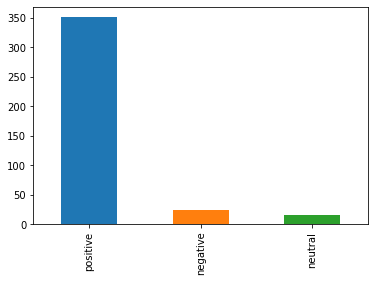

In [22]:
_ = df['Sentiment'].value_counts().plot(kind='bar')

In [28]:
pos_reviews = df['Sentiment'].value_counts()['positive']
total_reviews = df['Sentiment'].value_counts().sum()

print('Percent Positive reviews:',round(pos_reviews*100/total_reviews,2),'%')

Percent Positive reviews: 90.23 %
